# Set up environment and packages

In [1]:
import sys
print(sys.executable)
import mesa
import jupyter
import numpy as np
import pandas as pd
import seaborn as sns
from mesa.datacollection import DataCollector
import random
from collections import Counter
print(mesa.__version__)

c:\Users\abigail.weeks\AppData\Local\Programs\Python\Python313\python.exe
3.2.0


# Import Developer Information and Fuel Type Characteristics 

In [2]:
#Upload batch of developer profiles and clean fuel_type
developer_states_incomplete = pd.read_excel("developer_states.xlsx")
developer_states_incomplete['fuel_type'] = developer_states_incomplete['fuel_type'].str.strip().str.lower()
#Upload characteristics of fuels and clean 
fuel_states=pd.read_excel("fuel_states.xlsx")
fuel_states['fuel_type'] = fuel_states['fuel_type'].str.strip().str.lower()
#merge fuel characteristics with developer profiles for complete data frame
developer_states=developer_states_incomplete.merge(fuel_states, on='fuel_type', how='right')
new_projects_df=developer_states
#check merge 
developer_states.to_excel("developer_states_exported.xlsx", index=False)

# Import Node Information

In [3]:
node_states = pd.read_excel("node_states.xlsx")

# Set Up Agent, Node, and Model

In [ ]:
#Defining Developer Class
class DeveloperAgent(mesa.Agent):
#each of the Developer States upon Initiation
    def __init__(self, model, unique_id, fuel_type, size, risk_tolerance, developer, elcc, bid_price, chosen_node, service_type, construction_time, study_time_at_entry, assigned_cost, online=False):
        super().__init__(model)
        self.model=model
        self.unique_id = unique_id
        self.fuel_type = fuel_type
        self.size = size
        self.risk_tolerance = risk_tolerance
        self.developer= developer
        self.elcc=elcc
        self.past_wins = 0
        self.past_dropouts = 0
        self.internal_step_count=0
        self.construction_time = None
        self.study_time_at_entry=study_time_at_entry
        self.online = online
        self.bid_price = 0
        self.assigned_cost=None
        self.chosen_node=None
        self.service_type=None
        self.projects_at_node_total = 0
        self.projects_at_node_nris = 0
        self.projects_at_node_eris = 0
#Defining the Functions 
#Get summary stats of this developer's past projects.
    def get_past_developer_performance(self):
        past_developer = []
        for round_data in self.model.round_results:
            for entry in round_data:
                if entry.get("developer") == self.developer:
                    past_developer.append(entry)
        return past_developer
    def get_past_node_performance(self):
        past_node = []
        for node_summary in self.model.node_summary:
            for entry in node_summary:
                if entry.get("unique_id") == self.chosen_node:
                    past_node.append(entry)
        return past_node
#Choosing Node
    def choose_node(self):
        past_projects = self.get_past_developer_performance()
        # 1. Avoid nodes where this developer dropped out recently
        N = 3
        bad_nodes = set()
        for round_data in self.model.round_results[-N:]:
            for entry in round_data:
                if entry.get("dropped_out") and entry.get("developer") == self.developer:
                    bad_nodes.add(entry.get("chosen_node"))

        # 2. Prepare scores for ranking
        valid_nodes = [n for n in self.model.nodes if n.unique_id not in bad_nodes]

        # Gather values for ranking
        lmp_vals = [n.lmp for n in valid_nodes]
        queue_vals = [n.queue_size_normalized for n in valid_nodes]
        size_vals=[n.Generation for n in valid_nodes]

        # Normalize rankings: lower rank = better
        size_ranks= {n.unique_id: rank 
                     for rank, n in enumerate(sorted(valid_nodes, key=lambda x: -x.Generation[-1]))}
        lmp_ranks = {
            n.unique_id: rank
            for rank, n in enumerate(sorted(valid_nodes, key=lambda x: -x.lmp[-1]))}
        queue_ranks = {n.unique_id: rank for rank, n in enumerate(sorted(valid_nodes, key=lambda x: x.queue_size_normalized))}
    #new transmission factor
        last_round = self.model.round_results[-1] if len(self.model.round_results) > 0 else []
        nu_cost_ranks = {}
        if last_round:
            # Filter last round for this tech
            tech_entries = [e for e in last_round if e.get("fuel_type") == self.fuel_type]
            nu_costs = {}
            for entry in tech_entries:
                node_id = entry.get("chosen_node")
                nu_costs[node_id] = entry.get("NU_cost", 0)

            sorted_nu = sorted(nu_costs.items(), key=lambda x: x[1])
            for i, (node_id, _) in enumerate(sorted_nu):
                nu_cost_ranks[node_id] = i

        # 3. Score all valid nodes
        scored_nodes = []

        for node in valid_nodes:
            lmp_score = lmp_ranks[node.unique_id]
            queue_score = queue_ranks[node.unique_id]
            nu_score = nu_cost_ranks.get(node.unique_id, len(valid_nodes)) 
            size_score = size_ranks.get(node.unique_id, len(valid_nodes)) 

            # Bias by fuel type
            if self.fuel_type in ["solar", "solar_storage"]:
                fuel_bias = node.percent_solar
            elif self.fuel_type == "wind":
                fuel_bias = node.percent_wind
            else:
                fuel_bias = 0

            random_adder = random.uniform(-1, 1)

            # Composite score (lower is worse, so multiply by -1)
            score = -1 * (size_score+lmp_score + queue_score + fuel_bias + nu_score + random_adder)

            scored_nodes.append((node, score))

        # Sort by score descending (higher score = better)
        scored_nodes.sort(key=lambda x: x[1], reverse=True)

        # Pick one randomly from the top 3
        top_n = 3
        top_choices = scored_nodes[:min(top_n, len(scored_nodes))]
        chosen_node = random.choice(top_choices)[0]

        self.chosen_node = chosen_node.unique_id
    def step(self):
            
        self.internal_step_count+=1

        
        


In [5]:
#Defining the Node CLass
class Node(mesa.Agent):
#each of the Node States upon Initiation
    def __init__(self, model, Generation, unique_id, lmp, congestion_cost, available_capacity_round_0,mw_threshold_adder_1,  nu_tier_0, nu_tier_1,
                 	nu_tier_2, nu_cost_per_mw,	queue_size_normalized,	bid_price_round_0, construction_delay_factor, percent_wind, percent_solar,
                    total_projects, total_nris, total_eris, eris_mw, nris_mw):
        super().__init__(model)
        self.unique_id = unique_id
        self.congestion_cost = congestion_cost
        self.lmp=[lmp]
        self.available_capacity_round_0 = available_capacity_round_0
        self.mw_threshold_adder_1 = mw_threshold_adder_1
        self.nu_tier_0 = nu_tier_0
        self.nu_tier_1 = nu_tier_1
        self.nu_tier_2 = nu_tier_2
        self.nu_cost_per_mw = nu_cost_per_mw
        self.queue_size_normalized = queue_size_normalized
        self.bid_price_round_0 = bid_price_round_0
        self.construction_delay_factor=construction_delay_factor
        self.percent_solar=percent_solar
        self.percent_wind=percent_wind
        self.Generation=[Generation]
        self.total_projects=0
        self.total_nris=0
        self.total_eris=0
        self.eris_mw=0
        self.nris_mw=0
        
    def update_congestion_cost(self):
        self.eris_mw=sum(dev.size for dev in self.model.agents_by_type[DeveloperAgent]
            if dev.chosen_node==self.unique_id and getattr(dev,"service_type")=="ERIS")
        self.nris_mw=sum(dev.size for dev in self.model.agents_by_type[DeveloperAgent]
            if dev.chosen_node==self.unique_id and getattr(dev,"service_type")=="NRIS")
        self.congestion_cost=float(self.congestion_cost-(self.eris_mw/100))
    def step(self):
        self.update_congestion_cost()

In [ ]:
class InterconnectionModel(mesa.Model):
    def __init__(self, developer_states, node_states, new_projects_df, capacity_price=289,
                  base_construction=1, seed=None):
        super().__init__(seed=seed)
        self.new_projects_df = new_projects_df
        self.base_construction=base_construction
        self.round_results = [] 
        self.round_summary=[]
        self.nodes = []
        self.node_summary_list = []
        self.current_study_time=0
        self.total_capacity_reference=27000000
        self.system_marginal_energy_cost=[1.0]
        self.projects_per_node=[]
        self.capacity_price = capacity_price
        self.capacity_prices=[capacity_price]
        self.nris_added_last_round = []
        self.ERIS_differentiation=0
        self.ERIS_study_factor=.8
        self.ERIS_NU_factor=.8
        self.study_time=None
        self.restudy_factor=0
        self.datacollector = mesa.DataCollector(
        model_reporters={
            "num_total_projects": lambda m: len(m.agents_by_type[DeveloperAgent]),
            "num_dropped_out": lambda m: sum(1 for d in m.agents_by_type[DeveloperAgent] if getattr(d, "dropped_out", False)),
            "num_online": lambda m: sum(1 for d in m.agents_by_type[DeveloperAgent] if getattr(d, "online", False)),
            "MW_online": lambda m: sum(d.size for d in m.agents_by_type[DeveloperAgent] if d.online),
            "capacity_price": lambda m: m.capacity_price,
            "ERIS_num_projects": lambda m: sum(
                1 for d in m.agents_by_type[DeveloperAgent]
                if getattr(d, "service_type", None) == "ERIS" and getattr(d, "online", False)
            ),
            "ERIS_MW": lambda m: sum(
                d.size for d in m.agents_by_type[DeveloperAgent]
                if getattr(d, "service_type", None) == "ERIS" and getattr(d, "online", False)
            ),
            "NRIS_num_projects": lambda m: sum(
                1 for d in m.agents_by_type[DeveloperAgent]
                if getattr(d, "service_type", None) == "NRIS" and getattr(d, "online", False)
            ),
            "NRIS_MW": lambda m: sum(
                d.size for d in m.agents_by_type[DeveloperAgent]
                if getattr(d, "service_type", None) == "NRIS" and getattr(d, "online", False)
            ),
            "system_marginal_energy_cost": lambda m: m.current_system_marginal_energy_cost,
            "ERIS_to_NRIS_MW_ratio": lambda m: (
                sum(d.size for d in m.agents_by_type[DeveloperAgent] if getattr(d, "service_type", None) == "ERIS") /
                max(1, sum(d.size for d in m.agents_by_type[DeveloperAgent] if getattr(d, "service_type", None) == "NRIS"))
            ),
            "node_total_projects": lambda m: [node.total_projects for node in m.nodes],
            "node_total_eris": lambda m: [node.total_eris for node in m.nodes],
            "node_total_nris": lambda m: [node.total_nris for node in m.nodes],
            "node_congestion_cost": lambda m: [node.congestion_cost for node in m.nodes],
            "projects_per_node": lambda m: [node.total_projects for node in m.nodes],
        }
    )

        
        # ──────── Load DeveloperAgents ────────
        for i, row in developer_states.iterrows():
            bid_price=0
            agent = DeveloperAgent(
                unique_id=row['unique_id'],
                model=self,
                fuel_type=row['fuel_type'],
                size=row['size'],
                risk_tolerance=row['risk_tolerance'],
                developer=row['developer'],
                elcc=row['ELCC'],
                construction_time=None,
                study_time_at_entry=None,
                assigned_cost=None,
                chosen_node=None, 
                service_type=None,
                bid_price=bid_price
            )
            
        
        # ──────── Load Nodes ────────
        for i, row in node_states.iterrows():
            node = Node(
                unique_id=row['unique_id'],
                model=self,
                congestion_cost=row['congestion_cost'],
                lmp = row['lmp'],
                available_capacity_round_0=row['available_capacity_round_0'],
                mw_threshold_1=row['mw_threshold_1'],
                mw_threshold_2=row['mw_threshold_2'],
                nu_tier_0=row['nu_tier_0'],
                nu_tier_1=row['nu_tier_1'],
                nu_tier_2=row['nu_tier_2'],
                nu_cost_per_mw=row['nu_cost_per_mw'],
                queue_size_normalized=row['queue_size_normalized'],
                construction_delay_factor=row['construction_delay_factor'],
                percent_solar=row['percent_solar'],
                percent_wind=row['percent_wind'],
                Generation=row['generation'],
                total_eris=0,
                total_nris=0,
                total_projects=0,
                eris_mw=0,
                nris_mw=0
            )
            self.nodes.append(node)
        node_ids = [node.unique_id for node in self.nodes]
    ### Defining Model Level Functions 
    # Add new Developer Agents after round 0    
    def add_new_projects(self):
        if self.steps < 1:
            return 
        for i, row in self.new_projects_df.iterrows():
            new_unique_id = f"{row['unique_id']}_round{self.steps}"
            agent = DeveloperAgent(
                unique_id=new_unique_id,
                model=self,
                fuel_type=row['fuel_type'],
                size=row['size'],
                risk_tolerance=row['risk_tolerance'],
                developer=row['developer'],
                study_time_at_entry=None,
                assigned_cost=None,
                elcc=row['ELCC'],
                chosen_node=None,
                service_type=None,
                construction_time=None
            )
    def get_node_counts(self):
        if self.chosen_node is None:
            return 0, 0, 0
        node = next(n for n in self.model.nodes if n.unique_id == self.chosen_node)
        return node.total_projects, node.total_nris, node.total_eris    
    #Have each Developer Choose between NRIS and ERIS 
    def choose_service_type(self):
        for dev in self.agents_by_type[DeveloperAgent]:
        #only choose service in the first round the Agent exisits
            if dev.internal_step_count == 0:
        #a check for developers having chosen a node
                if dev.chosen_node is None:
                    continue
        #define node as the node the developer chose 
                node = next(n for n in self.nodes if n.unique_id == dev.chosen_node)
        #pass the node characteristic to this function
                total_nris = node.total_nris
        #if ERIS is studied the same and assigned the same costs as NRIS 
        #then the study_factors are 1 and the base probability of ERIS is 0
                base_prob_eris = ((1 - self.ERIS_study_factor) + (1 - self.ERIS_NU_factor)) / 2
        #ERIS projcts can use the infrastructure built by NRIS projects [free riding]
        #so if they are at a node with recent NRIS build out, they would be more willing to choose ERIS
        #because they think they will be dispatched more
        #technologies that will be dispatched first or would otherwise stand to make most
        #money in the energy market (batteries) are more willing to choose ERIS
                if self.ERIS_NU_factor !=0:
                    free_ride_factor = min(total_nris / 20, 1)
                    if dev.fuel_type=="storage":
                        fuel_factor=.1
                    if dev.fuel_type=="solar_storage":
                        fuel_factor=.1
                    if dev.fuel_type=="solar":
                        fuel_factor=.05
                    if dev.fuel_type=="wind":
                        fuel_factor=.05
                else:
                    free_ride_factor=0
                    fuel_factor=0
        #the overall probability of choosing ERIS is the sum of the base probability and factors
                eris_prob = base_prob_eris + free_ride_factor+fuel_factor
        #random.random() generates a number between 0 and 1, so the higher the eris_prob, 
        #the higher chance the developer will have service_type as ERIS
                if random.random() < eris_prob:
                    dev.service_type = 'ERIS'
                else:
                    dev.service_type = 'NRIS'

        # Every three steps, a project that is currently ERIS may choose to switch to NRIS
        if dev.internal_step_count % 3 == 0:
            if dev.service_type == "ERIS":
                if random.random() < 0.05:
                    dev.service_type = "NRIS"
    #Assign network upgrade costs to developers
    def assign_costs(self):
        # Precompute total MW applying for this node this round for developers not dropped out
        node_total_mw = {}
        for dev in self.agents_by_type[DeveloperAgent]:
            if getattr(dev, "dropped_out", False) or dev.chosen_node is None or dev.internal_step_count>0:
                continue
            node_total_mw[dev.chosen_node] = node_total_mw.get(dev.chosen_node, 0) + dev.size
        # Assign costs based on total MW at each node in a piecewise fashion
        for dev in self.agents_by_type[DeveloperAgent]:
            if getattr(dev, "dropped_out", False) or dev.chosen_node is None or dev.internal_step_count>0:
                continue
            node = next((n for n in self.nodes if n.unique_id == dev.chosen_node), None)
            total_mw = node_total_mw.get(dev.chosen_node, 0)
            node_threshold_1 = getattr(node, "mw_threshold_1")
            node_threshold_2 = getattr(node, "mw_threshold_2")
            nu_tier_0 = getattr(node, "nu_tier_0")
            nu_tier_1=getattr(node, "nu_tier_1")
            nu_tier_2=getattr(node, "nu_tier_2")

            # Piecewise cost
            if total_mw < node_threshold_1:
                assigned_cost = nu_tier_0 * dev.size
            elif node_threshold_1 <= total_mw <= node_threshold_2:
                assigned_cost = nu_tier_1 * dev.size
            elif node_threshold_2 < total_mw:
                assigned_cost=nu_tier_2 *dev.size

            # If ERIS differentiation is True, then the assigned cost for ERIS is the less of
            #tier_0 times size or assigned_cost*nu_cost_factor
            if self.ERIS_differentiation and getattr(dev, "service_type", None) == "ERIS":
                assigned_cost = min(nu_tier_0 * dev.size, assigned_cost * self.ERIS_nu_cost_factor)
            dev.assigned_cost = assigned_cost
    #reassign network upgrade costs to developers (this function is called if dropouts are high)
    def reassign_costs(self):
        # Precompute total MW applying for this node this round for developers not dropped out
        node_total_mw = {}
        for dev in self.agents_by_type[DeveloperAgent]:
            if getattr(dev, "dropped_out", False) or dev.chosen_node is None or dev.internal_step_count>0:
                continue
            node_total_mw[dev.chosen_node] = node_total_mw.get(dev.chosen_node, 0) + dev.size
        # Assign costs based on total MW at each node in a piecewise fashion
        for dev in self.agents_by_type[DeveloperAgent]:
            if getattr(dev, "dropped_out", False) or dev.chosen_node is None or dev.internal_step_count>0:
                continue
            node = next((n for n in self.nodes if n.unique_id == dev.chosen_node), None)
            total_mw = node_total_mw.get(dev.chosen_node, 0)
            node_threshold_1 = getattr(node, "mw_threshold_1")
            node_threshold_2 = getattr(node, "mw_threshold_2")
            nu_tier_0 = getattr(node, "nu_tier_0")
            nu_tier_1=getattr(node, "nu_tier_1")
            nu_tier_2=getattr(node, "nu_tier_2")

            # Piecewise cost function
            if total_mw < node_threshold_1:
                assigned_cost = nu_tier_0 * dev.size
            elif node_threshold_1 <= total_mw <= node_threshold_2:
                assigned_cost = nu_tier_1 * dev.size
            elif node_threshold_2 < total_mw:
                assigned_cost=nu_tier_2 *dev.size

            # If ERIS differentiation is True, then the assigned cost for ERIS is the less of
            #tier_0 times size or assigned_cost*nu_cost_factor
            if self.ERIS_differentiation and getattr(dev, "service_type", None) == "ERIS":
                assigned_cost = min(nu_tier_0 * dev.size, assigned_cost * self.ERIS_nu_cost_factor)
            dev.assigned_cost = assigned_cost
            self.restudy_factor=1
    #Make developers dropout of queue if certain conditions are met 
    def apply_dropout(self):
        num_devs = len(self.agents_by_type[DeveloperAgent])
        num_dropped = 0
        for dev in self.agents_by_type[DeveloperAgent]:
            if dev.internal_step_count == 0:
                if hasattr(dev, 'assigned_cost') and hasattr(dev, 'size') and hasattr(dev, 'service_type'):
                    if dev.service_type == "ERIS":
    # ERIS dropout if assigned cost is greater than their dropout threshold * risk tolerance 
    #dropout_threshold for ERIS projects is their ATB
    #risk toleranceis a random number
                        if dev.assigned_cost > dev.atb_capex*dev.atb_capex_multiplier*dev.risk_tolerance: #units are in $/MW
                            dev.dropped_out = True
                        else:
                            dev.dropped_out = False
    #dropout_threshold for NRIS projects is their ATB+ Anticipated Capacity Market Revenue
                    elif dev.service_type == "NRIS":
                        if dev.assigned_cost> dev.atb_capex*dev.atb_capex_multiplier*dev.risk_tolerance+self.capacity_price * 365 * dev.elcc*20  #units are in $/MW
                            dev.dropped_out= True
                        else:
                            dev.dropped_out = False
                    if dev.dropped_out:
                        num_dropped +=1
   
    # Re-run assign_costs if dropout > 40%
                    if num_devs > 0 and (num_dropped / num_devs) > 0.4:
                        self.reassign_costs()


#Calculate the total node NU costs, MW added, and avg cost/mw for this round
    def calculate_node_network_upgrade_costs(self):
        node_costs = {}
        for dev in self.agents_by_type[DeveloperAgent]:
            node = dev.chosen_node  
        node_costs[node]['total_cost'] += dev.assigned_cost
        node_costs[node]['total_size'] += dev.size
        self.node_nu_costs = {}
        self.node_nu_costs_per_mw = {}
        self.node_size = {}
        for node_id, vals in node_costs.items():
                total_cost = vals['total_cost']
                total_size = vals['total_size']
                avg_nu_cost_per_MW = vals['total_cost'] / vals['total_size']
        self.node_nu_costs[node_id] = total_cost
        self.node_nu_costs_per_mw[node_id] = avg_nu_cost_per_MW
        self.node_size[node_id] = total_size
    #Assign Study Time 
    def assign_study_time(self):
        #the study time is 1 and if a restudy occured then the study time is 1+restudy_factor (0 or 1)
        self.study_time = 1+self.restudy_factor
        #if the developer is ERIS then the study time is a fraction of the model study time
        #for NRIS the study time is the model study time
        for dev in self.agents_by_type[DeveloperAgent]:
            if getattr(dev, "service_type", None) == "ERIS":
                dev.study_time = self.study_time * self.ERIS_study_factor
            else:
                dev.study_time_at_entry = self.study_time
    #Assign Construction Time
    #the construction time of a developer is a function of the assigned network upgrade costs 
    # and node specific delays, to a max of 7 years 
    def assign_construction_time(self):
        for dev in self.agents_by_type[DeveloperAgent]:
            if getattr(dev, "dropped_out", False):
             continue
            node = next((n for n in self.nodes if n.unique_id == dev.chosen_node), None)
            delay_factor = getattr(node, "construction_delay_factor", 0)  
            dev.construction_time = min(dev.assigned_cost / 100 + delay_factor, 7)
            
    #Come online
    def update_online_status(self):
        for dev in self.agents_by_type[DeveloperAgent]:
            if not dev.online:
                if dev.study_time is not None and dev.construction_time is not None:
                    if dev.internal_step_count >= int(dev.study_time + dev.construction_time):
                        dev.online = True
    #Update Total Generation
    def update_total_capacity(self):
        print(f"Before update: total_capacity_reference = {self.total_capacity_reference}")
        for dev in self.agents_by_type[DeveloperAgent]:
            if dev.online:
                self.total_capacity_reference += dev.size
    # Update Capacity Price
    def update_capacity_price(self):
        last_price = self.capacity_prices[-1]
        new_online_mw = 0
        for dev in self.agents_by_type[DeveloperAgent]:
         if dev.online and dev.internal_step_count == int(self.current_study_time + dev.construction_time) + 1:
            new_online_mw += dev.size
        new_price = last_price * (1 - (new_online_mw)/self.total_capacity_reference)
        self.capacity_prices.append(new_price)
        print(self.total_capacity_reference)
        print(new_online_mw)
        self.capacity_price = new_price
    def update_system_marginal_energy_cost(self):
        last_price = self.system_marginal_energy_cost[-1]
        print(f"last_price: {last_price}")
        new_online_bid_price_sum = 0.0
        new_online_count = 0

        for dev in self.agents_by_type[DeveloperAgent]:
            if (dev.online and dev.internal_step_count == int(dev.study_time_at_entry + dev.construction_time) + 1):
                new_online_bid_price_sum += dev.bid_price
                new_online_count += 1

        print(f"new_online_bid_price_sum: {new_online_bid_price_sum}")
        print(f"new_online_count: {new_online_count}")
        print(f"total_capacity_reference: {self.total_capacity_reference}")

        if new_online_count:
            avg_new_online_bid_price = new_online_bid_price_sum / new_online_count
        else:
            avg_new_online_bid_price = 0.0

        print(f"avg_new_online_bid_price: {avg_new_online_bid_price}")

        if self.total_capacity_reference == 0:
            print("Warning: total_capacity_reference is zero! Adjusting to 1 to avoid division by zero.")
            self.total_capacity_reference = 1  # or handle differently

        new_price = last_price * (1 - avg_new_online_bid_price / self.total_capacity_reference)
        print("  new_price:", new_price)

        self.system_marginal_energy_cost.append(new_price)
        self.current_system_marginal_energy_cost = new_price
    def count_nodes(self):
        for dev in self.agents_by_type[DeveloperAgent]:
            if getattr(dev, "service_type", None) == "NRIS" and getattr(dev, "added_this_round", False):
                self.nris_added_last_round[dev.chosen_node] = (
                    self.nris_added_last_round.get(dev.chosen_node, 0) + 1
            )
    #build transmisison for nodes with lowest congestion adder (could also do this by zone, if I make a zone piece of the puzzle and assign nodes 
    #to it like a network proxy)
    def build_transmission (self):
          node_congestion = [(node, node.congestion_cost) for node in self.agents_by_type[Node]]
          top_nodes = sorted(node_congestion, key=lambda x: x[1], reverse=True)[:5]
          for node, _ in top_nodes:
              node.congestion_cost -= 5
    
    #Define order of Functions for each Step in Model
    def step(self):
        self.add_new_projects()
        for dev in self.agents_by_type[DeveloperAgent]:
            if dev.internal_step_count == 0:
             dev.choose_node()
        self.choose_service_type()
        self.assign_costs()
        self.apply_dropout()
        self.assign_study_time()
        self.assign_construction_time()
        self.update_online_status()
        self.update_total_capacity()
        self.update_capacity_price()
        self.update_system_marginal_energy_cost()
        for node in self.nodes:
            node.step()
        
        round_data = []
        
        for dev in self.agents_by_type[DeveloperAgent]:
            node_obj = next((n for n in self.nodes if n.unique_id == dev.chosen_node), None)
            round_data.append({
            "dev_id": dev.unique_id,
            "step": dev.internal_step_count,
            "chosen_node": int(dev.chosen_node) if dev.chosen_node is not None else None,
            "dropped_out": getattr(dev, "dropped_out", False),
            "developer": dev.developer,
            "assigned_cost": dev.assigned_cost,
            "assigned_study_time": dev.study_time_at_entry,
            "assigned_construction_time": getattr(dev, "construction_time", None),
            "online": dev.online,
            "Model Step":self.steps,
            "Capacity Price":self.capacity_price,
            "Service_Type": dev.service_type,
            "Bid Price": dev.bid_price,
        })
        self.round_results.append(round_data)
        self.projects_per_node = [node.total_projects for node in self.nodes]
        self.datacollector.collect(self)
          # ── 4. model‑level summary stats for this round ──────────────────────────
        num_total   = len(self.agents_by_type[DeveloperAgent])
        num_dropped = sum(1 for d in self.agents_by_type[DeveloperAgent] if getattr(d, "dropped_out", False))
        num_online = sum(1 for d in self.agents_by_type[DeveloperAgent] if getattr(d, "online", False))
        total_online_mw = sum(d.size for d in self.agents_by_type[DeveloperAgent] if d.online)
        capacity_price=self.capacity_price
        
        # ERIS counts and MW
        eris_agents = [d for d in self.agents_by_type[DeveloperAgent] if getattr(d, "service_type", None) == "ERIS"]
        eris_num_projects = len(eris_agents)
        eris_mw = sum(d.size for d in eris_agents)

# NRIS counts and MW
        nris_agents = [d for d in self.agents_by_type[DeveloperAgent] if getattr(d, "service_type", None) == "NRIS"]
        nris_num_projects = len(nris_agents)
        nris_mw = sum(d.size for d in nris_agents)
        summary = {
            "model_step": self.steps,
            "num_total_projects": num_total,
            "num_dropped_out": num_dropped,
            "num_online": num_online,
            "MW_online": total_online_mw,
            "capacity_price": capacity_price,
            "ERIS_num_projects": eris_num_projects,
            "ERIS_MW": eris_mw,
            "NRIS_num_projects": nris_num_projects,
            "NRIS_MW": nris_mw,
            "system_marginal_energy_cost": self.current_system_marginal_energy_cost,
            }
        self.round_summary.append(summary)
        node_summary =[]
        for node in self.nodes:
    # Count developers assigned to this node
            for node in self.nodes:
                devs_at_node = [
                dev for dev in self.agents_by_type[DeveloperAgent] 
                if dev.chosen_node == node.unique_id
            ]
        node.total_projects = len(devs_at_node)
        node.total_nris = sum(1 for dev in devs_at_node if dev.service_type == "NRIS")
        node.total_eris = sum(1 for dev in devs_at_node if dev.service_type == "ERIS")
        node_summary.append({
            "model_step": self.steps,
            "node_id": node.unique_id,
            "lmp": node.lmp,
            "available_capacity_round_0": node.available_capacity_round_0,
            "queue_size_normalized": node.queue_size_normalized,
            "num_projects": node.total_projects,
            "congestion_cost": node.congestion_cost
        })
        self.node_summary_list.append(node_summary)
        self.build_transmission()
            # Remove dropped out developers
        for dev in list(self.agents_by_type[DeveloperAgent]):
            if getattr(dev, "dropped_out", False):
                dev.remove()
        self.agents.shuffle_do("step")


    

# Running the Model

In [7]:
capacity_price=289 
model_instance = InterconnectionModel(developer_states, node_states, new_projects_df, capacity_price)
for _ in range(5):
    model_instance.step()
print("Final projects per node:", model_instance.projects_per_node)
projects_list = [round_data.get("projects_per_node", {}) for round_data in model_instance.round_summary]

projects_df = pd.DataFrame(projects_list).fillna(0).astype(int)
print(projects_df)
    
# Use your model instance name
flat_results = [entry for round_data in model_instance.round_results for entry in round_data]


# Convert to DataFrame
df = pd.DataFrame(flat_results)

# Save to CSV
df.to_csv("developer_round_results.csv", index=False)
df2 = pd.DataFrame(model_instance.round_summary)  # Make sure you pass the list of dicts here

df2.to_csv('model_round_summary.csv', index=False)
for start in range(0, len(df2), 50):
    print(df2.iloc[start:start+50])
print("Steps taken:", model_instance.steps)
print("Length of round_summary:", len(model_instance.round_summary))

all_node_rows = [row for step_list in model_instance.node_summary_list for row in step_list]
node_summary_df = pd.DataFrame(all_node_rows)
node_summary_df.to_csv('node_round_summary.csv')


KeyError: 'mw_threshold_adder_1'

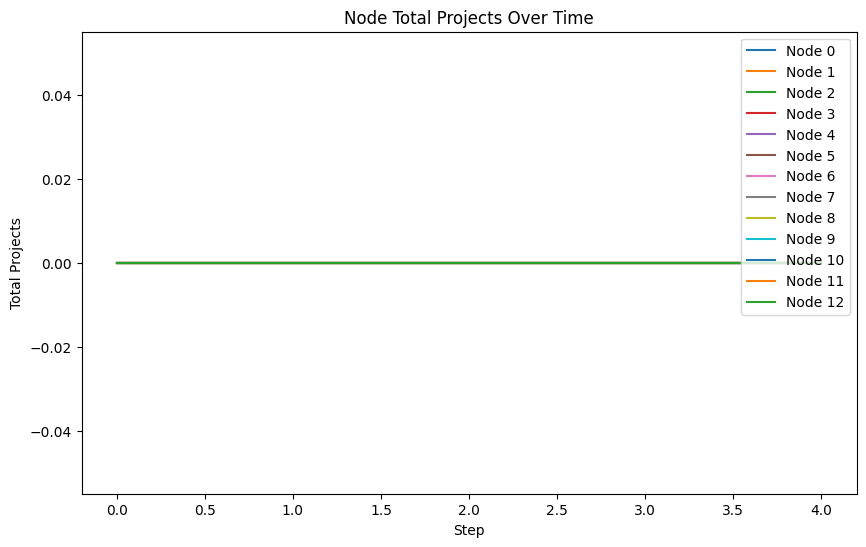

In [ ]:
from mesa.visualization import SolaraViz, make_plot_component, Slider
import solara
model_params = {
    "developer_states": developer_states,
    "node_states": node_states,
    "capacity_price": capacity_price,
    "new_projects_df": new_projects_df,
    "base_construction": 1,
    "seed": None
}

# Your agent portrayal function
def agent_portrayal(agent):
    color = "gray"
    if hasattr(agent, "fuel_type"):
        if agent.fuel_type == "solar":
            color = "yellow"
        elif agent.fuel_type == "wind":
            color = "green"
        elif agent.fuel_type == "natural_gas":
            color = "red"

    label = getattr(agent, "chosen_node", "None")

    return {
        "color": color,
        "size": 50,
        "label": f"{agent.fuel_type}\n{label}"
    }
print(model_params.keys())

# Now define the visualization using your model class (not instance)
page = SolaraViz(
    model_instance,  # <-- Pass class, not instance
    [
        make_plot_component(["NRIS_num_projects", "ERIS_num_projects", "num_online"]),
        make_plot_component(["NRIS_MW", "ERIS_MW"]),
        make_plot_component("system_marginal_energy_cost"),
        #make_plot_component("average_revenue"),
        #make_plot_component("num_total_projects"),
        make_plot_component("num_dropped_out"),
        #make_plot_component("num_online"),
       #make_plot_component("MW_online"),
        make_plot_component ("capacity_price"),
        #make_plot_component ("projects_per_node"),
        #make_plot_component("ERIS_to_NRIS_MW_ratio"),
        #make_plot_component(["node_total_projects", "node_total_eris", "node_total_nris", "node_congestion_cost"])
    ],
    model_params=model_params
)


page



dict_keys(['developer_states', 'node_states', 'capacity_price', 'new_projects_df', 'base_construction', 'seed'])


Cannot show ipywidgets in text

In [ ]:
parameters = {
    "developer_states": [developer_states],   # note the list with one DataFrame
    "node_states": [node_states],
    "new_projects_df": [new_projects_df],
    "capacity_price": [capacity_price],
    "base_construction": [1],
}

results = mesa.batch_run(
    InterconnectionModel,
    parameters,
    iterations=4,
    max_steps=20,
    data_collection_period=1,
    number_processes=1,
)
results_df = pd.DataFrame(results)

# Export to CSV
results_df.to_csv("batch_run_results.csv", index=False)


  0%|          | 0/4 [00:00<?, ?it/s]

Before update: total_capacity_reference = 27000000
27000000
0
last_price: 1.0
new_online_bid_price_sum: 0.0
new_online_count: 0
total_capacity_reference: 27000000
avg_new_online_bid_price: 0.0
  new_price: 1.0
Before update: total_capacity_reference = 27000000
27000000
0
last_price: 1.0
new_online_bid_price_sum: 0.0
new_online_count: 0
total_capacity_reference: 27000000
avg_new_online_bid_price: 0.0
  new_price: 1.0
Before update: total_capacity_reference = 27000000
Adding dev.size = 100.0 for dev AF2-350
After adding: total_capacity_reference = 27000100.0
Adding dev.size = 150.0 for dev AF2-142
After adding: total_capacity_reference = 27000250.0
Adding dev.size = 200.0 for dev AF2-200
After adding: total_capacity_reference = 27000450.0
Adding dev.size = 300.0 for dev AF2-041
After adding: total_capacity_reference = 27000750.0
Adding dev.size = 126.0 for dev AG1-008
After adding: total_capacity_reference = 27000876.0
Adding dev.size = 126.0 for dev AF2-046
After adding: total_capacity_

In [ ]:
from mesa.visualization import SolaraViz, make_plot_component, Slider

model_params = {
    "capacity_price": capacity_price,
    "developer_states": developer_states,
    "node_states": node_states,
    "new_projects_df": new_projects_df,
    "base_construction": 1,
    "seed": None
}

# Your agent portrayal function (unchanged)
def agent_portrayal(agent):
    color = "gray"
    if hasattr(agent, "fuel_type"):
        if agent.fuel_type == "solar":
            color = "yellow"
        elif agent.fuel_type == "wind":
            color = "green"
        elif agent.fuel_type == "natural_gas":
            color = "red"

    label = getattr(agent, "chosen_node", "None")

    return {
        "color": color,
        "size": 50,
        "label": f"{agent.fuel_type}\n{label}"
    }

# Define slider for capacity_price parameter
capacity_price_slider = Slider(
    min=0.5,
    max=1.5,
    step=0.01,
    value=model_params["capacity_price"],
    label="Capacity Price"
)

# Now define the visualization including the slider
page = SolaraViz(
    model_instance,  # Note: pass the model class, not instance
    [
        capacity_price_slider,  # Add slider here
        make_plot_component(["NRIS_num_projects", "ERIS_num_projects", "num_online"]),
        make_plot_component(["NRIS_MW", "ERIS_MW"]),
        make_plot_component("system_marginal_energy_cost"),
        make_plot_component("num_dropped_out"),
        make_plot_component("capacity_price"),
    ],
    model_params=model_params
)

page


Component react.component(mesa.visualization.solara_viz.WrappedComponent) raised exception TypeError("'Slider' object is not callable")
Traceback (most recent call last):
  File "c:\Users\abigail.weeks\AppData\Local\Programs\Python\Python313\Lib\site-packages\reacton\core.py", line 1702, in _render
    root_element = el.component.f(*el.args, **el.kwargs)
  File "c:\Users\abigail.weeks\AppData\Local\Programs\Python\Python313\Lib\site-packages\mesa\visualization\solara_viz.py", line 210, in WrappedComponent
    return component(model)
TypeError: 'Slider' object is not callable


Cannot show ipywidgets in text